In [1]:
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sns 

In [2]:
class ScrimLog():
    def __init__(self, match_id=None):
        self.match_id = match_id # match_id = filename
        self.set_directory()
        self.set_df_merge()

    def set_directory(self):
        path = 'C:/Users/jyc13/Documents/Overwatch/Workshop'
        filename = self.match_id + '.csv'
        filepath = os.path.join(path, filename)
        self.df_init = pd.read_csv(filepath)
    
    def set_df_merge(self):
        grouping = ['Map', 'Section', 'Timestamp', 'Team', 'Player', 'Hero']
        df_group = self.df_init.groupby(grouping).sum()
        dx = df_group.groupby([x for x in grouping if x != 'Timestamp']).diff().fillna(0)
        df_merge = pd.merge(df_group, dx, how='outer', left_index=True, right_index=True, suffixes=('', '/s'))
    
        section_list = df_merge.reset_index('Section')['Section'].unique()
        player_list = df_merge.reset_index('Player')['Player'].unique()

        rolling = pd.DataFrame()

        for section in section_list:
            for player in player_list:
                df_tmp = df_merge.xs((section, player), level=['Section', 'Player'], drop_level=False)
                rolling_tmp = df_tmp.groupby(by=['Map', 'Section','Team', 'Timestamp']).sum()
                rolling_tmp = rolling_tmp.rolling(window=10).sum().fillna(rolling_tmp)
                rolling = pd.concat([rolling, rolling_tmp])

        alives = 6 - rolling.groupby(by=['Map', 'Section', 'Timestamp', 'Team']).sum()[['Deaths/s']]
        alives.rename(columns = {'Deaths/s':'Alives'}, inplace=True)
        team_one_name = self.df_init['Team'].unique()[0]
        team_two_name = self.df_init['Team'].unique()[1]

        X = alives.xs(team_one_name, level='Team', drop_level=False)
        Y = alives.xs(team_two_name, level='Team', drop_level=False)

        def RCP(X, Y):
            df_merge = pd.merge(X, Y, how='outer', on=[x for x in X.index.names if x != 'Team'], suffixes=(f'_{team_one_name}', f'_{team_two_name}'))
            df_merge['RCP'] = (df_merge[f'Alives_{team_one_name}']**2 - df_merge[f'Alives_{team_two_name}']**2) / (df_merge[[f'Alives_{team_one_name}', f'Alives_{team_two_name}']].max(axis=1)) # Af = (A0^2 - B0^2)/A0

            return df_merge    

        RCP = RCP(X, Y)

        self.df_merge = pd.merge(df_merge, RCP, how='outer', left_index=True, right_index=True)
    
    def get_df_merge(self):
        return self.df_merge

In [5]:
scrim = ScrimLog('210316_NYE_vs_BLG_Busan')
df_merge = scrim.get_df_merge()

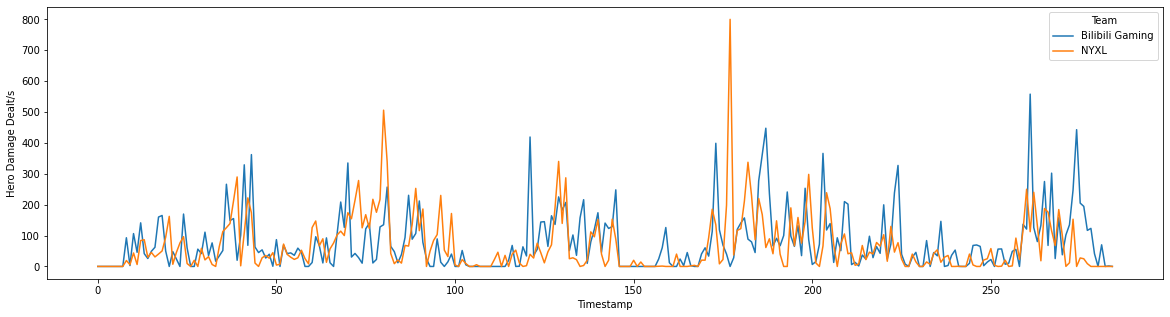

In [6]:
plt.figure(figsize=(20,5))
sns.lineplot(x='Timestamp', y='Hero Damage Dealt/s', data=df_merge.xs(('Busan', 2), level=['Map', 'Section'], drop_level=False).groupby(by=['Map', 'Section', 'Timestamp', 'Team']).sum(), hue='Team')
plt.show()